In [1]:
import pandas as pd
import quantstats as qs
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
import sys
import numpy
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
numpy.set_printoptions(threshold=sys.maxsize)

**Importando dados e inserindo o dia como coluna**

In [2]:
dados_empresas = pd.read_csv("historico_acoes.csv")
dados_empresas['data'] = pd.to_datetime(dados_empresas['data'])
dados_empresas = dados_empresas.set_index('data')
dados_empresas['day'] = dados_empresas.index.day

**Importando o calendário da B3 com os dias em que houveram negociações**

In [3]:
calendar = mcal.get_calendar('B3')
dias = calendar.valid_days(start_date = '2011-10-01', end_date = '2023-09-30')
dias = pd.DataFrame({'Dias': dias})
dias = dias.set_index('Dias')
dias['year'] = dias.index.year
dias['month'] = dias.index.month
dias['day'] = dias.index.day
dias

,year,month,day
Dias,,,
2011-10-03 00:00:00+00:00,2011,10,3
2011-10-04 00:00:00+00:00,2011,10,4
2011-10-05 00:00:00+00:00,2011,10,5
2011-10-06 00:00:00+00:00,2011,10,6
2011-10-07 00:00:00+00:00,2011,10,7
...,...,...,...
2023-09-25 00:00:00+00:00,2023,9,25
2023-09-26 00:00:00+00:00,2023,9,26
2023-09-27 00:00:00+00:00,2023,9,27


**Filtrando o último dia de negociação de cada mês**

In [4]:
ultimo_dia = dias.groupby([dias['year'], dias['month']]).idxmax()
ultimo_dia = ultimo_dia['day'].reset_index()['day']
ultimo_dia = pd.DataFrame(index=ultimo_dia)
ultimo_dia = ultimo_dia.index.strftime('%Y-%m-%d')
ultimo_dia

Index(['2011-10-31', '2011-11-30', '2011-12-29', '2012-01-31', '2012-02-29',
       '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', '2012-07-31',
       ...
       '2022-12-29', '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-28',
       '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-29'],
      dtype='object', name='day', length=144)

**Função para filtrar uma base de dados pelos últimos dias de cada mês do calendário da B3**

In [5]:
def seleciona_filtro(dados):
    A = dados.index.strftime('%Y-%m-%d')
    B = list(set(A) & set(ultimo_dia))
    mask = dados.index.isin(B)
    dados = dados[mask]
    return dados

**Aplicando a função a base de dados das empresas**

In [6]:
dados_empresas_filtrado = dados_empresas.groupby('ticker').apply(seleciona_filtro)
dados_empresas_filtrado.reset_index(level=[0], drop = True, inplace = True)
dados_empresas_filtrado.head()

,ticker,fechamento_ajustado,EV_EBIT,ROIC,EBIT_EV,valor_de_mercado,year,month,day
data,,,,,,,,,
2016-12-29,AALR3,14.45,11.38260,0.05890,0.087853,7.313816e+08,2016,12,29
2017-01-31,AALR3,13.75,11.09781,0.05890,0.090108,7.004290e+08,2017,1,31
2017-02-24,AALR3,12.56,10.50525,0.05890,0.095190,6.360274e+08,2017,2,24
2017-03-31,AALR3,15.41,19.96784,0.05517,0.050081,1.700502e+09,2017,3,31
2017-04-28,AALR3,18.32,24.28460,0.05517,0.041178,2.134819e+09,2017,4,28


**Calculando os retornos mensais das ações entre os dias de negociação e aplicando um cálculo de retorno médio mensal**

(Algumas ações apresentam _gap_ entre um mês e outro, sendo necessário a conversão para retorno mensal)

In [15]:
dados_empresas_filtrado['retorno'] = dados_empresas_filtrado.groupby('ticker')['fechamento_ajustado'].pct_change()
dados_empresas_filtrado['retorno'] = dados_empresas_filtrado.groupby('ticker')['retorno'].shift(-1)

dados_empresas_filtrado['diferenca'] = (dados_empresas_filtrado.index - pd.Series(dados_empresas_filtrado.index).shift()).values
dados_empresas_filtrado['diferenca'] = (dados_empresas_filtrado['diferenca'] / timedelta(days=1)).shift(-1)
dados_empresas_filtrado.dropna(inplace=True)
dados_empresas_filtrado['retorno_medio_mensal'] = (1 + dados_empresas_filtrado['retorno']) ** (21 / dados_empresas_filtrado['diferenca']) - 1

dados_empresas.dropna(inplace=True)
dados_empresas_filtrado.dropna(inplace=True)
dados_empresas_filtrado

,ticker,fechamento_ajustado,EV_EBIT,ROIC,EBIT_EV,valor_de_mercado,year,month,day,retorno,diferenca,retorno_medio_mensal,ranking_ev_ebit,ranking_roic,ranking_final
data,,,,,,,,,,,,,,,
2016-12-29,AALR3,14.45,11.38260,0.05890,0.087853,7.313816e+08,2016,12,29,-0.048443,33.0,-0.031105,76.0,111.0,90.0
2017-01-31,AALR3,13.75,11.09781,0.05890,0.090108,7.004290e+08,2017,1,31,-0.086545,24.0,-0.076151,72.0,114.0,90.0
2017-02-24,AALR3,12.56,10.50525,0.05890,0.095190,6.360274e+08,2017,2,24,0.226911,35.0,0.130545,64.0,117.0,86.0
2017-03-31,AALR3,15.41,19.96784,0.05517,0.050081,1.700502e+09,2017,3,31,0.188838,28.0,0.138524,131.0,124.0,138.0
2017-04-28,AALR3,18.32,24.28460,0.05517,0.041178,2.134819e+09,2017,4,28,-0.045306,33.0,-0.029073,137.0,119.0,135.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,ZAMP3,4.81,25.00702,0.02483,0.039989,1.318953e+09,2023,2,28,-0.033264,31.0,-0.022656,260.0,257.0,275.0
2023-03-31,ZAMP3,4.65,18.34562,0.03526,0.054509,1.280403e+09,2023,3,31,-0.096774,28.0,-0.073496,247.0,257.0,269.0
2023-04-28,ZAMP3,4.20,17.06482,0.03526,0.058600,1.156493e+09,2023,4,28,-0.092857,33.0,-0.060133,250.0,255.0,269.0


**Criando um ranking com os indicadores para realizar a seleção da carteira a partir dos melhores indicadores**

In [8]:
dados_empresas_filtrado['ranking_ev_ebit'] = dados_empresas_filtrado.groupby('data')['EBIT_EV'].rank(ascending = False)
dados_empresas_filtrado['ranking_roic'] = dados_empresas_filtrado.groupby('data')['ROIC'].rank(ascending = False)

dados_empresas_filtrado['ranking_final'] = dados_empresas_filtrado['ranking_ev_ebit'] + dados_empresas_filtrado['ranking_roic']
dados_empresas_filtrado['ranking_final'] = dados_empresas_filtrado.groupby('data')['ranking_final'].rank()

**Filtragem da base de dados para manter apenas as 10 melhores ações**

In [9]:
carteira_top_10_filtrado = dados_empresas_filtrado[dados_empresas_filtrado['ranking_final'] <= 10]
carteira_top_10_filtrado

,ticker,fechamento_ajustado,EV_EBIT,ROIC,EBIT_EV,valor_de_mercado,year,month,day,retorno,diferenca,retorno_medio_mensal,ranking_ev_ebit,ranking_roic,ranking_final
data,,,,,,,,,,,,,,,
2012-03-30,AELP3,33.81,2.02488,0.21163,0.493856,3.549578e+09,2012,3,30,-0.287193,62.0,-0.108338,1.0,25.0,3.0
2012-05-31,AELP3,24.10,1.74754,0.17597,0.572233,2.414549e+09,2012,5,31,-0.035685,29.0,-0.025970,1.0,33.0,5.0
2012-06-29,AELP3,23.24,1.70565,0.17597,0.586287,2.328044e+09,2012,6,29,-0.240534,63.0,-0.087633,1.0,36.0,6.0
2012-08-31,AELP3,17.65,2.09492,0.16465,0.477345,1.806159e+09,2012,8,31,-0.045892,28.0,-0.034621,3.0,37.0,7.0
2012-11-30,AFLU3,3.50,5.18031,0.20460,0.193039,5.913130e+07,2012,11,30,0.054286,90.0,0.012411,19.0,26.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-31,WHRL4,2.12,5.03483,0.33724,0.198616,5.814353e+09,2015,3,31,0.028302,30.0,0.019728,23.5,11.5,8.5
2015-04-30,WHRL4,2.18,5.00400,0.33724,0.199840,5.781882e+09,2015,4,30,0.000000,29.0,0.000000,16.5,8.5,3.5
2015-07-31,WHRL4,1.70,5.29562,0.23581,0.188835,4.709357e+09,2015,7,31,-0.011765,31.0,-0.007985,22.0,14.0,6.5


**Cálculo de rentabilidade da carteira selecionada considerando pesos iguais**

In [10]:
rentabilidade_carteira = carteira_top_10_filtrado.groupby('data')['retorno_medio_mensal'].mean()
rentabilidade_carteira = rentabilidade_carteira.to_frame()
rentabilidade_carteira['retorno_modelo'] = (rentabilidade_carteira['retorno_medio_mensal'] + 1).cumprod() - 1
rentabilidade_carteira = rentabilidade_carteira.shift(1)
rentabilidade_carteira = rentabilidade_carteira.dropna()
print(rentabilidade_carteira)

            retorno_medio_mensal  retorno_modelo
data                                            
2011-11-30             -0.005017       -0.005017
2011-12-29             -0.002290       -0.007295
2012-01-31              0.044582        0.036961
2012-02-29              0.033353        0.071547
2012-03-30             -0.020925        0.049125
...                          ...             ...
2023-04-28             -0.014690        3.992308
2023-05-31             -0.000839        3.988121
2023-06-30              0.076889        4.371653
2023-07-31              0.000738        4.375618
2023-08-31              0.005555        4.405481

[141 rows x 2 columns]


<Axes: xlabel='data'>

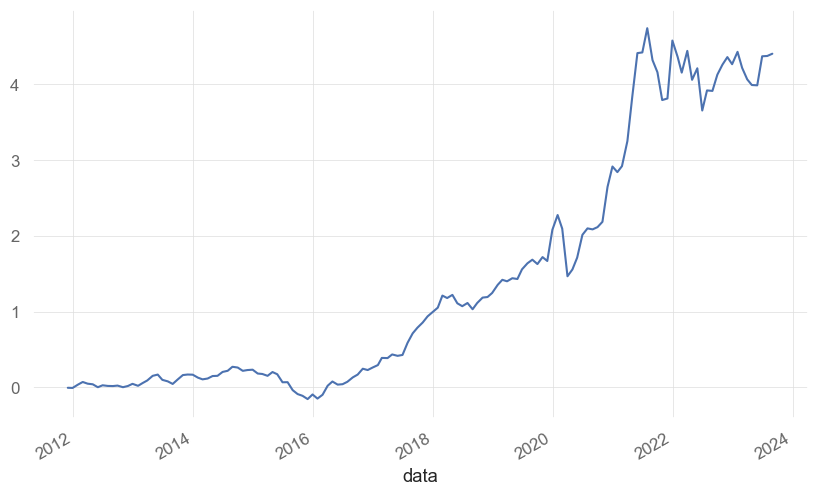

In [11]:
rentabilidade_carteira['retorno_modelo'].plot()

**Importação das cotações do Ibovespa, filtragem pelo mesmo período da base de dados das ações e cálculo da rentabilidade acumulada**

In [12]:
ibov = yf.download('^BVSP', '2009-01-01', '2023-10-18')
ibov.index = pd.to_datetime(ibov.index)
mask = ibov.index.isin(dados_empresas_filtrado.index)
filtered_ibov = ibov[mask]

retornos_ibov = filtered_ibov['Adj Close'].pct_change().dropna()
retorno_acumulado_ibov = (1 + retornos_ibov).cumprod() - 1

rentabilidade_carteira['ibovespa'] = retorno_acumulado_ibov.values
rentabilidade_carteira = rentabilidade_carteira.drop('retorno_medio_mensal', axis = 1)

[*********************100%%**********************]  1 of 1 completed


**Gráfico do retorno acumulado do modelo _versus_ Ibovespa no período**

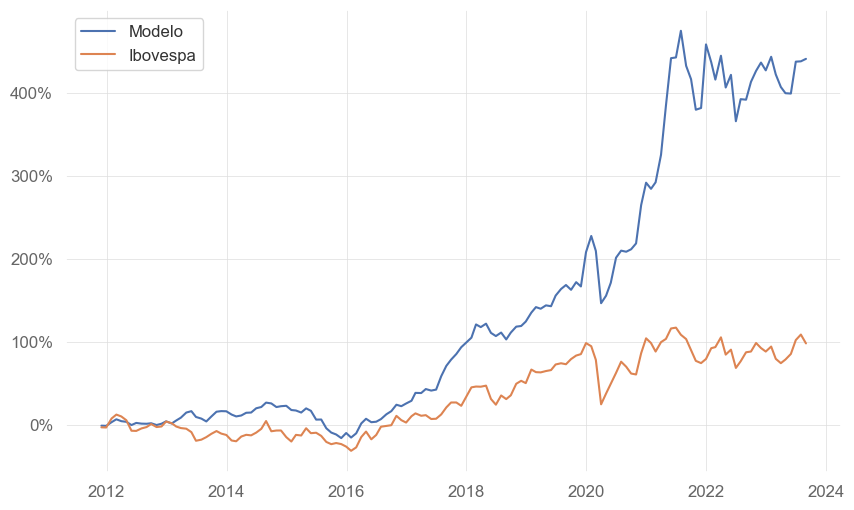

In [13]:
fig, ax = plt.subplots()
ax.plot(rentabilidade_carteira.index, rentabilidade_carteira['retorno_modelo'], label = 'Modelo')
ax.plot(rentabilidade_carteira.index, rentabilidade_carteira['ibovespa'], label = 'Ibovespa')
ax.legend(loc = 'upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))